In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import time

df = pd.read_csv('data/Pregnancy-During-the-COVID-19-Pandemic.csv')
df_bruto = pd.read_csv('data/Pregnancy-During-the-COVID-19-Pandemic.csv')

In [164]:
df.head()

,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Language,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,1,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,English,2,3,27
1,2,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,English,2,33,92
2,3,34.3,"$100,000 -$124,999",Undergraduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,French,,,
3,4,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,French,53,67,54
4,5,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,English,23,32,71


In [165]:
df.shape # qtd de linhas e colunas

(10772, 16)

In [166]:
# dropa colunas desnecessárias
df.drop(columns = ["OSF_ID","Language"], inplace = True)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38.3,"$200,000+",Masters degree,9.0,13.0,39.71,Dec2020,49.20,3431.0,Vaginally,No,2,3,27
1,34.6,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,2,33,92
2,34.3,"$100,000 -$124,999",Undergraduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
3,28.8,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,Dec2020,41.00,2534.0,Vaginally,No,53,67,54
4,36.5,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,Oct2020,53.34,3714.0,Caesarean-section (c-section),No,23,32,71


In [167]:
# substituindo espaços em branco por "NaN" (nulo), para interpretação correta
df.replace(" ", np.nan, inplace=True)

In [168]:
# checar existência de linhas duplicadas
# o duplicated() considera duplicação a repetição de valores de uma linha inteira (todas as colunas)
# importante lembrar que se linhas possuem valores null nas mesmas colunas elas tbm são consideradas duplicatas
df.duplicated().sum()

np.int64(43)

In [169]:
# calcula a % de valores nulos que cada coluna possui
df.isnull().mean()*100

Maternal_Age                                   1.030449
Household_Income                               2.330115
Maternal_Education                             1.643149
Edinburgh_Postnatal_Depression_Scale          10.898626
PROMIS_Anxiety                                11.195693
Gestational_Age_At_Birth                      37.486075
Delivery_Date(converted to month and year)    37.495358
Birth_Length                                  49.127367
Birth_Weight                                  43.575938
Delivery_Mode                                 48.598218
NICU_Stay                                     48.626068
Threaten_Life                                  8.317861
Threaten_Baby_Danger                           8.392128
Threaten_Baby_Harm                             8.280728
dtype: float64

In [170]:
# mostra a qtd de colunas com valores null em cada linha
null_count = df.isnull().sum(axis=1)
print(null_count)

0         0
1         6
2        11
3         0
4         0
         ..
10767     6
10768    11
10769     6
10770     6
10771     3
Length: 10772, dtype: int64


In [171]:
# removendo linhas com +10 valores nulos 
df = df[null_count <= 10]
df.shape

(10245, 14)

In [172]:
# por serem colunas importantes, as linhas que possuem valores nulos nas colunas Edinburgh_Postnatal_Depression_Scale,
# PROMIS_Anxiety, Threaten_Life, Threaten_Baby_Danger e Threaten_Baby_Harm serão dropadas ao invés de terem seu valor substituído
# por alguma medida de tendência central (como moda, média e mediana) pois seriam valores "falsos", gerados artificialmente.
# Essa decisão foi tomada pois as colunas citadas têm porcentagens consideradas baixas para presença de valores nulos como foi
# mostrado (11.19%, 8.31%, 8.39% e 8.28% respectivamente)

df = df.dropna(subset=['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm', 'PROMIS_Anxiety', 'Edinburgh_Postnatal_Depression_Scale'])

In [173]:
df.shape

(9566, 14)

In [174]:
# inexistência de valores duplicados
df.duplicated().sum()

np.int64(0)

In [175]:
df.drop(columns = ["Delivery_Date(converted to month and year)"], inplace = True) # DROPAR delivery_date pois não será usada
#df.rename(columns={'Delivery_Date(converted to month and year)': 'Delivery_Date'}, inplace=True)
#df.head()

<Axes: ylabel='Frequency'>

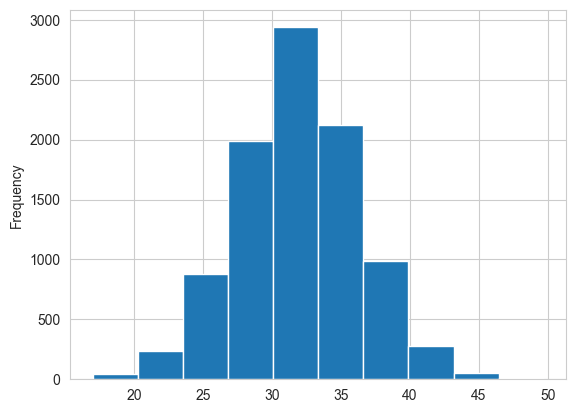

In [176]:
# checando se existem outliers em Maternal_Age
df["Maternal_Age"].plot.hist()

In [177]:
# substituindo valores nulos pela média, que foi escolhida por não haver presença de outliers significativos
# foi decidido substituir porque a porcentagem de NaNs é baixíssima e não é vantajoso excluir
# linhas onde Maternal_Age é nula
df["Maternal_Age"].fillna(df["Maternal_Age"].mean(), inplace=True)
df["Maternal_Age"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [178]:
# convertendo valores de Maternal_Age para inteiro (arredondamento)
df["Maternal_Age"] = df["Maternal_Age"].round().astype(int)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38,"$200,000+",Masters degree,9.0,13.0,39.71,49.20,3431.0,Vaginally,No,2,3,27
1,35,"$200,000+",Undergraduate degree,4.0,17.0,NaN,NaN,NaN,NaN,NaN,2,33,92
3,29,"$100,000 -$124,999",Masters degree,9.0,20.0,38.57,41.00,2534.0,Vaginally,No,53,67,54
4,36,"$40,000-$69,999",Undergraduate degree,14.0,20.0,39.86,53.34,3714.0,Caesarean-section (c-section),No,23,32,71
5,38,"$150,000 - $174,999",Undergraduate degree,3.0,8.0,38.57,NaN,NaN,NaN,NaN,29,36,33


In [179]:
# ver quais são os valores únicos de Household_Income
df["Household_Income"].unique()

array(['$200,000+', '$100,000 -$124,999', '$40,000-$69,999',
       '$150,000 - $174,999', '$70,000-$99,999', '$175,000- $199,999',
       '$125,000- $149,999', '$20,000- $39,999', 'Less than $20, 000',
       nan], dtype=object)

In [180]:
# ver quais são os valores únicos de Maternal_Education
df["Maternal_Education"].unique()

array(['Masters degree', 'Undergraduate degree', 'High school diploma',
       'College/trade school', 'Less than high school diploma',
       'Doctoral Degree', nan], dtype=object)

In [181]:
# precisamos fazer ENCODING em algumas features para que possam ser interpretadas corretamente pelos modelos.
# serão feitos one-hot encoding nas colunas NICU_Stay e Delivery_Mode, assim não corre o risco de seus valores serem interpretados
# do jeito errado (por exemplo criando distâncias inexistentes entre certos valores, mantendo a equidistância entre eles).
# Label Encoding será feito nas colunas Household_Income e Maternal_Education

# substituindo NaNs por unknown em Household_Income
df['Household_Income'] = df['Household_Income'].fillna('Unknown')
df['Household_Income'].unique()

array(['$200,000+', '$100,000 -$124,999', '$40,000-$69,999',
       '$150,000 - $174,999', '$70,000-$99,999', '$175,000- $199,999',
       '$125,000- $149,999', '$20,000- $39,999', 'Less than $20, 000',
       'Unknown'], dtype=object)

In [182]:
# dicionário de levels
household_level = {
    'Unknown': 0,
    'Less than $20, 000': 1,
    '$20,000- $39,999': 2,
    '$40,000-$69,999': 3,
    '$70,000-$99,999': 4,
    '$100,000 -$124,999': 5,
    '$125,000- $149,999': 6,
    '$150,000 - $174,999': 7,
    '$175,000- $199,999': 8,
    '$200,000+': 9,
}

# substituindo valores pelos levels
df['Household_Income'] = df['Household_Income'].replace(household_level).infer_objects(copy=False).astype(int)
df['Household_Income'].head(10)

C:\Users\ricoz\AppData\Local\Temp\ipykernel_24980\429889731.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Household_Income'] = df['Household_Income'].replace(household_level).infer_objects(copy=False).astype(int)


0     9
1     9
3     5
4     3
5     7
6     9
8     5
10    4
13    4
14    9
Name: Household_Income, dtype: int64

In [183]:
# substituindo NaNs por unknown em Maternal_Education
df["Maternal_Education"] = df["Maternal_Education"].fillna("Unknown")
df["Maternal_Education"].unique()

array(['Masters degree', 'Undergraduate degree', 'High school diploma',
       'College/trade school', 'Less than high school diploma',
       'Doctoral Degree', 'Unknown'], dtype=object)

In [184]:
# dicionário de levels
education_level = {
    'Unknown': 0,
    'Less than high school diploma': 1,
    'High school diploma': 2,
    'College/trade school': 3,
    'Undergraduate degree': 4,
    'Masters degree': 5,
    'Doctoral Degree': 6,
}

# substituindo valores pelos levels
df["Maternal_Education"] = df["Maternal_Education"].replace(education_level).infer_objects(copy=False).astype(int)
df["Maternal_Education"].head(10)

C:\Users\ricoz\AppData\Local\Temp\ipykernel_24980\2029550412.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Maternal_Education"] = df["Maternal_Education"].replace(education_level).infer_objects(copy=False).astype(int)


0     5
1     4
3     5
4     4
5     4
6     2
8     3
10    1
13    5
14    6
Name: Maternal_Education, dtype: int64

In [185]:
# visualizar dados
df.head(10)

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm
0,38,9,5,9.0,13.0,39.71,49.20,3431.0,Vaginally,No,2,3,27
1,35,9,4,4.0,17.0,NaN,NaN,NaN,NaN,NaN,2,33,92
3,29,5,5,9.0,20.0,38.57,41.00,2534.0,Vaginally,No,53,67,54
4,36,3,4,14.0,20.0,39.86,53.34,3714.0,Caesarean-section (c-section),No,23,32,71
5,38,7,4,3.0,8.0,38.57,NaN,NaN,NaN,NaN,29,36,33
6,34,9,2,8.0,15.0,NaN,NaN,NaN,NaN,NaN,24,30,32
8,33,5,3,1.0,7.0,40.86,55.88,4480.0,Vaginally,No,27,76,72
10,29,4,1,20.0,28.0,NaN,NaN,NaN,NaN,NaN,0,50,98
13,29,4,5,14.0,17.0,41.00,47.00,3084.0,Vaginally,No,68,69,81
14,32,9,6,3.0,14.0,30.29,32.00,1050.0,Caesarean-section (c-section),Yes,30,30,50


In [186]:
# one-hot encoding

# NICU_Stay
# substituindo valores NaN por unknown
df["NICU_Stay"] = df["NICU_Stay"].fillna("Unknown")
df["NICU_Stay"].unique()

array(['No', 'Unknown', 'Yes'], dtype=object)

In [187]:
# criando as colunas do encoding
df = pd.get_dummies(df, columns=["NICU_Stay"], dtype=int)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Delivery_Mode,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes
0,38,9,5,9.0,13.0,39.71,49.20,3431.0,Vaginally,2,3,27,1,0,0
1,35,9,4,4.0,17.0,NaN,NaN,NaN,NaN,2,33,92,0,1,0
3,29,5,5,9.0,20.0,38.57,41.00,2534.0,Vaginally,53,67,54,1,0,0
4,36,3,4,14.0,20.0,39.86,53.34,3714.0,Caesarean-section (c-section),23,32,71,1,0,0
5,38,7,4,3.0,8.0,38.57,NaN,NaN,NaN,29,36,33,0,1,0


In [188]:
# Delivery_Mode
# substituindo valores NaN por unknown
df["Delivery_Mode"] = df["Delivery_Mode"].fillna("Unknown")
df["Delivery_Mode"].unique()

array(['Vaginally', 'Unknown', 'Caesarean-section (c-section)'],
      dtype=object)

In [189]:
# criando as colunas do encoding
df = pd.get_dummies(df, columns=["Delivery_Mode"], dtype=int)
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean-section (c-section),Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,13.0,39.71,49.20,3431.0,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,17.0,NaN,NaN,NaN,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,20.0,38.57,41.00,2534.0,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,20.0,39.86,53.34,3714.0,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,8.0,38.57,NaN,NaN,29,36,33,0,1,0,0,1,0


<Axes: ylabel='Frequency'>

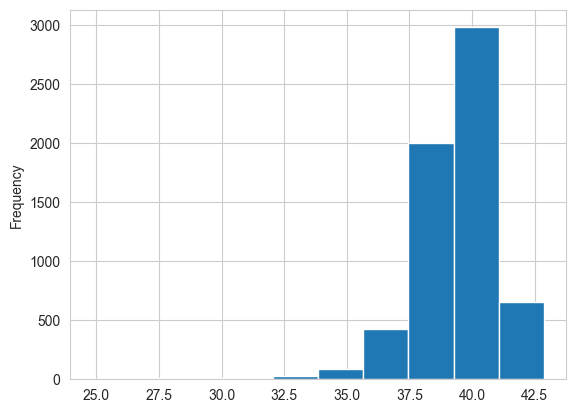

In [190]:
# encontrando outliers em outras colunas para encontrar melhor medida de tendência central para substituição
# de nulos: média, moda ou mediana
df["Gestational_Age_At_Birth"].plot.hist()

<Axes: ylabel='Frequency'>

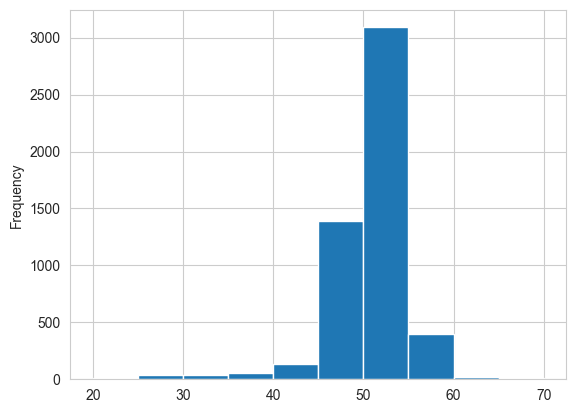

In [191]:
df["Birth_Length"].plot.hist()

<Axes: ylabel='Frequency'>

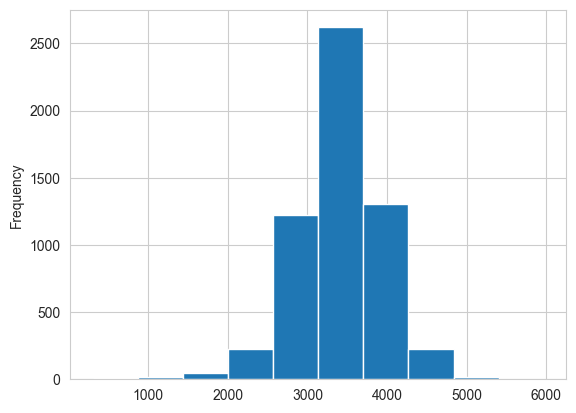

In [192]:
df["Birth_Weight"].plot.hist()

In [193]:
# substituindo nulos em Gestational_Age_At_Birth pela sua média
df["Gestational_Age_At_Birth"].fillna(df["Gestational_Age_At_Birth"].mean(), inplace=True)
df["Gestational_Age_At_Birth"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [194]:
# substituindo nulos em Birth_Length pela sua média
df["Birth_Length"].fillna(df["Birth_Length"].mean(), inplace=True)
df["Birth_Length"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [195]:
# substituindo nulos em Birth_Length pela sua média
df["Birth_Weight"].fillna(df["Birth_Weight"].mean(), inplace=True)
# convertendo de gramas pra quilos
df["Birth_Weight"] = df["Birth_Weight"]/1000

df["Birth_Weight"].isnull().mean()*100 # 0% de valores nulos

np.float64(0.0)

In [196]:
# renomeando coluna para Delivery_Mode_Caesarean
df.rename(columns={'Delivery_Mode_Caesarean-section (c-section)': 'Delivery_Mode_Caesarean'}, inplace=True)
df.head(10)

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean,Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,13.0,39.710000,49.200000,3.431000,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,17.0,39.351094,50.499156,3.410886,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,20.0,38.570000,41.000000,2.534000,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,20.0,39.860000,53.340000,3.714000,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,8.0,38.570000,50.499156,3.410886,29,36,33,0,1,0,0,1,0
6,34,9,2,8.0,15.0,39.351094,50.499156,3.410886,24,30,32,0,1,0,0,1,0
8,33,5,3,1.0,7.0,40.860000,55.880000,4.480000,27,76,72,1,0,0,0,0,1
10,29,4,1,20.0,28.0,39.351094,50.499156,3.410886,0,50,98,0,1,0,0,1,0
13,29,4,5,14.0,17.0,41.000000,47.000000,3.084000,68,69,81,1,0,0,0,0,1
14,32,9,6,3.0,14.0,30.290000,32.000000,1.050000,30,30,50,0,0,1,1,0,0


In [197]:
# Agora o dataset não possui mais nenhum valor nulo. Pré-processamento feito.

Text(0.5, 1.0, 'Distribuição da Idade')

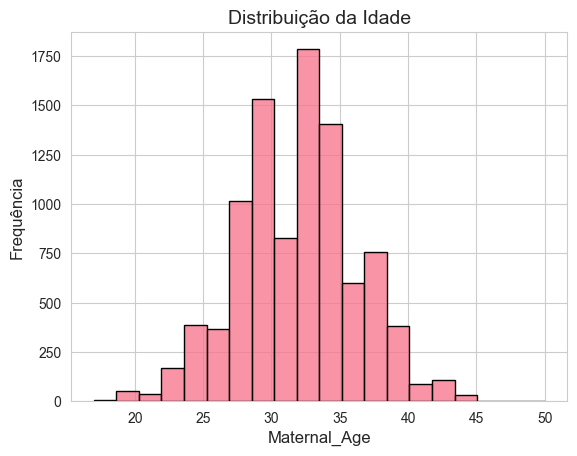

In [198]:
# Plotar algumas estatísticas das principais colunas

# Maternal_Age
sns.set_style("whitegrid")
sns.histplot(df['Maternal_Age'], bins=20, color=sns.color_palette("husl", 10)[0], edgecolor="black")

# Adicionar rótulos e título
plt.xlabel('Maternal_Age', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição da Idade", fontsize=14)

Text(0.5, 1.0, 'Distribuição da Escolaridade')

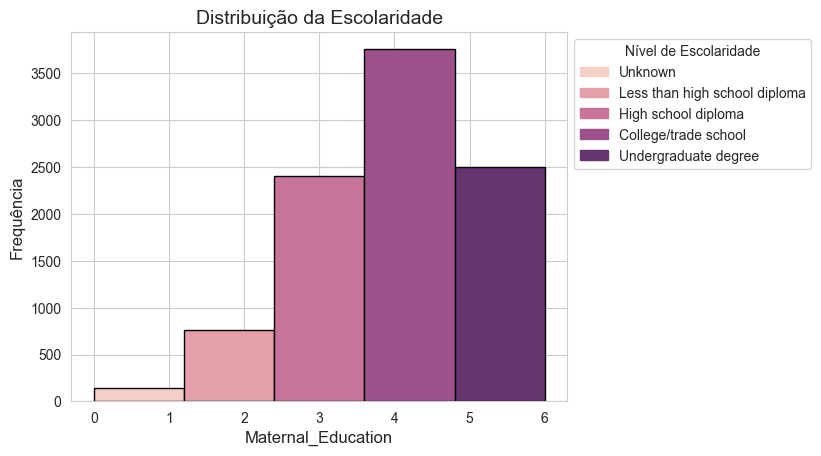

In [199]:
# Maternal_Education
sns.set_style("whitegrid")
ax = sns.histplot(df['Maternal_Education'], bins=5, edgecolor="black")
colors = sns.color_palette(sns.cubehelix_palette(hue=1), len(ax.patches))

for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

plt.legend(handles, education_level, title="Nível de Escolaridade", loc="upper left", bbox_to_anchor=(1, 1))

# Adicionar rótulos e título
plt.xlabel('Maternal_Education', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição da Escolaridade", fontsize=14)

Text(0.5, 1.0, 'Distribuição da Renda Familiar')

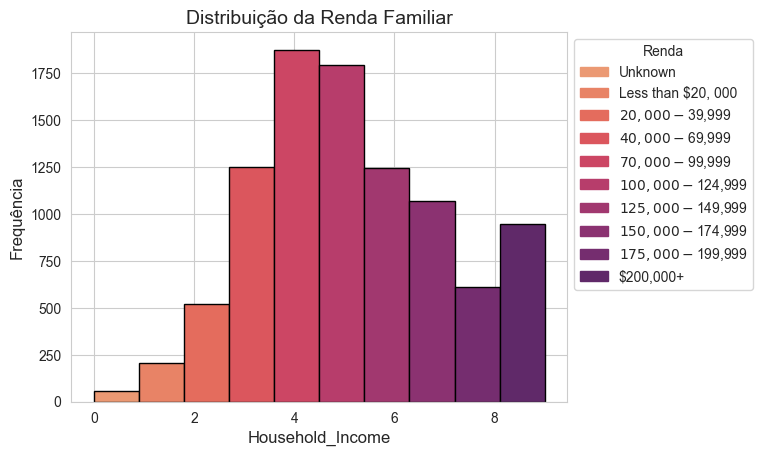

In [200]:
# Household_Income
sns.set_style("whitegrid")
ax = sns.histplot(df['Household_Income'], bins=10, edgecolor="black")
colors = sns.color_palette("flare", len(ax.patches))

for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

plt.legend(handles, household_level, title="Renda", loc="upper left", bbox_to_anchor=(1, 1))

# Adicionar rótulos e título
plt.xlabel('Household_Income', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição da Renda Familiar", fontsize=14)

In [201]:
# arredondamento de valores nas colunas
df = df.round({'Gestational_Age_At_Birth': 2, 'Birth_Length': 2, 'Birth_Weight': 2})
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean,Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,13.0,39.71,49.20,3.43,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,17.0,39.35,50.50,3.41,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,20.0,38.57,41.00,2.53,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,20.0,39.86,53.34,3.71,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,8.0,38.57,50.50,3.41,29,36,33,0,1,0,0,1,0


In [202]:
# extração de categorias
# os valores foram categorizados com base numa tabela de severidade da PROMIS_Anxiety
df['PROMIS_Anxiety'] = pd.cut(df["PROMIS_Anxiety"], bins=[-float("inf"), 15, 20, 28, float("inf")],
                              labels=["Nenhuma a Leve", "Pouca", "Moderada", "Severa"])
df.head()

,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean,Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,Nenhuma a Leve,39.71,49.20,3.43,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,Pouca,39.35,50.50,3.41,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,Pouca,38.57,41.00,2.53,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,Pouca,39.86,53.34,3.71,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,Nenhuma a Leve,38.57,50.50,3.41,29,36,33,0,1,0,0,1,0


Text(0.5, 1.0, 'Distribuição do Nível de Ansiedade')

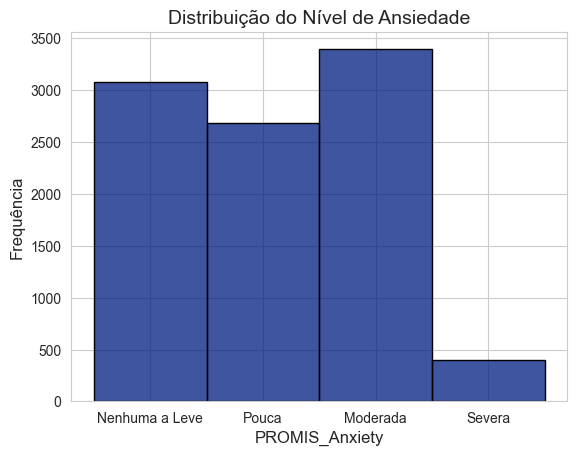

In [203]:
# PROMIS_Anxiety
sns.set_style("whitegrid")
sns.histplot(df['PROMIS_Anxiety'], bins=10, color=sns.color_palette(sns.color_palette("dark"))[0], edgecolor="black")

# Adicionar rótulos e título
plt.xlabel('PROMIS_Anxiety', fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title(f"Distribuição do Nível de Ansiedade", fontsize=14)

In [204]:
#df.to_csv('dataset.csv') # exportar o dataframe

In [205]:
# dicionário de levels
anxiety_level = {
    "Nenhuma a Leve": 0,
    "Pouca": 1,
    "Moderada": 2,
    "Severa": 3,
}

# substituindo valores pelos levels
df['PROMIS_Anxiety'] = df['PROMIS_Anxiety'].replace(anxiety_level).infer_objects(copy=False).astype(int)
df.head(10)

C:\Users\ricoz\AppData\Local\Temp\ipykernel_24980\409736230.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['PROMIS_Anxiety'] = df['PROMIS_Anxiety'].replace(anxiety_level).infer_objects(copy=False).astype(int)
C:\Users\ricoz\AppData\Local\Temp\ipykernel_24980\409736230.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['PROMIS_Anxiety'] = df['PROMIS_Anxiety'].replace(anxiety_level).infer_objects(copy=False).astype(int)


,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,NICU_Stay_No,NICU_Stay_Unknown,NICU_Stay_Yes,Delivery_Mode_Caesarean,Delivery_Mode_Unknown,Delivery_Mode_Vaginally
0,38,9,5,9.0,0,39.71,49.20,3.43,2,3,27,1,0,0,0,0,1
1,35,9,4,4.0,1,39.35,50.50,3.41,2,33,92,0,1,0,0,1,0
3,29,5,5,9.0,1,38.57,41.00,2.53,53,67,54,1,0,0,0,0,1
4,36,3,4,14.0,1,39.86,53.34,3.71,23,32,71,1,0,0,1,0,0
5,38,7,4,3.0,0,38.57,50.50,3.41,29,36,33,0,1,0,0,1,0
6,34,9,2,8.0,0,39.35,50.50,3.41,24,30,32,0,1,0,0,1,0
8,33,5,3,1.0,0,40.86,55.88,4.48,27,76,72,1,0,0,0,0,1
10,29,4,1,20.0,2,39.35,50.50,3.41,0,50,98,0,1,0,0,1,0
13,29,4,5,14.0,1,41.00,47.00,3.08,68,69,81,1,0,0,0,0,1
14,32,9,6,3.0,0,30.29,32.00,1.05,30,30,50,0,0,1,1,0,0


In [206]:
# Implementação do 10-fold cross-validation
# cria o CV com 10 folds para cada repetição, serão 5 repetições e a cada repetição
# o dataset será embaralhado, usando este CV o modelo vai ser executado 50 vezes
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

### DATASET PROCESSADO ###
# embaralhando data frame
df = sklearn.utils.shuffle(df)

# divisão de features e target
df_features = df.drop(columns=['PROMIS_Anxiety'])
df_target = df['PROMIS_Anxiety']

# instanciação de modelo
#knn = KNeighborsClassifier(n_neighbors=2)

# pipeline pra normalização e modelo
# a normalização deixa os valores da coluna entre 0 e 1, o que é importante para
# melhorar a precisão do knn, que seria ruim em caso de dados com escalas muito distantes
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # normaliza os dados pro intervalo [0,1]
    ('knn', KNeighborsClassifier(n_neighbors=2))
])

# cria métricas de avaliação
f1_scorer = make_scorer(f1_score, average='weighted')

# avaliação do modelo (a melhorar: mudar tipo de scoring)
# treina e avalia o modelo 50 vezes conforme o CV, dessa forma existirão 50 scores
# a média dos scores será usada como score final para avaliação do modelo
scores_f1 = cross_val_score(pipeline, df_features, df_target, scoring=f1_scorer, cv=cv, n_jobs=-1)
scores_acc = cross_val_score(pipeline, df_features, df_target, scoring='accuracy', cv=cv, n_jobs=-1)

# verificação de performance
# F1-Score
print('F1-Score: %.3f (%.3f)' % (np.mean(scores_f1)*100, np.std(scores_f1)))

# Acurácia
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_acc)*100, np.std(scores_acc)))

F1-Score: 50.713 (0.014)
Accuracy: 52.185 (0.013)


In [207]:
### DATASET BRUTO ###
# necessário fazer alguns pré-processamentos no dataset bruto para que ele consiga rodar os modelos

df_bruto = df_bruto.fillna({
    'Maternal_Age': df_bruto['Maternal_Age'].mean(),
    'Household_Income': 'Não informado',
    'Maternal_Education': 'Não informado',
    'Edinburgh_Postnatal_Depression_Scale': df_bruto['Edinburgh_Postnatal_Depression_Scale'].mean(),
    'PROMIS_Anxiety': df_bruto['PROMIS_Anxiety'].mean(),
    'Delivery_Date(converted to month and year)': 'Não informado',
    'Gestational_Age_At_Birth': df_bruto['Gestational_Age_At_Birth'].mean(),
    'Birth_Length': df_bruto['Birth_Length'].mean(),
    'Birth_Weight' : df_bruto['Birth_Weight'].mean(),
    'Delivery_Mode' : 'Não informado',
    'NICU_Stay': 'Não informado'
})

label_encoder = LabelEncoder()
l = ['','','']
cont = 0
columns = ['Household_Income','Maternal_Education','Delivery_Date(converted to month and year)']

for col in columns:
    l[cont] = df_bruto[col]
    df_bruto[col] = label_encoder.fit_transform(df_bruto[col])

scaler = MinMaxScaler()

columns_to_normalize = ['Delivery_Date(converted to month and year)']

df_bruto[columns_to_normalize] = scaler.fit_transform(df_bruto[columns_to_normalize])
df_bruto[columns_to_normalize] = df_bruto[columns_to_normalize] - np.min(df_bruto[columns_to_normalize])

categorical_columns = ['Delivery_Mode','NICU_Stay','Language']

df_bruto = pd.get_dummies(df_bruto, columns=categorical_columns)

df_bruto = df_bruto.drop(columns=['OSF_ID'])

#Tratamento de valores nulos
df_bruto.loc[df_bruto['Threaten_Life'] == ' ', ['Threaten_Life']] = 42
df_bruto.loc[df_bruto['Threaten_Baby_Danger'] == ' ', ['Threaten_Baby_Danger']] = 50
df_bruto.loc[df_bruto['Threaten_Baby_Harm'] == ' ', ['Threaten_Baby_Harm']] = 62

for x in range(101):
  df_bruto.loc[df_bruto['Threaten_Life'] == str(x), ['Threaten_Life']] = x
  df_bruto.loc[df_bruto['Threaten_Baby_Danger'] == str(x), ['Threaten_Baby_Danger']] = x
  df_bruto.loc[df_bruto['Threaten_Baby_Harm'] == str(x), ['Threaten_Baby_Harm']] = x

# levels
df_bruto['PROMIS_Anxiety'] = pd.cut(df_bruto["PROMIS_Anxiety"], bins=[-float("inf"), 15, 20, 28, float("inf")],
                              labels=["Nenhuma a Leve", "Pouca", "Moderada", "Severa"])

df_bruto['PROMIS_Anxiety'] = df_bruto['PROMIS_Anxiety'].replace(anxiety_level).infer_objects(copy=False).astype(int)

df_bruto.head(10)

C:\Users\ricoz\AppData\Local\Temp\ipykernel_24980\698551069.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bruto['PROMIS_Anxiety'] = df_bruto['PROMIS_Anxiety'].replace(anxiety_level).infer_objects(copy=False).astype(int)
C:\Users\ricoz\AppData\Local\Temp\ipykernel_24980\698551069.py:54: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_bruto['PROMIS_Anxiety'] = df_bruto['PROMIS_Anxiety'].replace(anxiety_level).infer_objects(copy=False).astype(int)


,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted to month and year),Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,Delivery_Mode_Caesarean-section (c-section),Delivery_Mode_Não informado,Delivery_Mode_Vaginally,NICU_Stay_No,NICU_Stay_Não informado,NICU_Stay_Yes,Language_English,Language_French
0,38.300000,5,4,9.000000,0,39.710000,0.172414,49.200000,3431.000000,2,3,27,False,False,True,True,False,False,True,False
1,34.600000,5,6,4.000000,1,39.342241,0.827586,50.502504,3412.175058,2,33,92,False,True,False,False,True,False,True,False
2,34.300000,0,6,10.194832,1,39.342241,0.827586,50.502504,3412.175058,42,50,62,False,True,False,False,True,False,False,True
3,28.800000,0,4,9.000000,1,38.570000,0.172414,41.000000,2534.000000,53,67,54,False,False,True,True,False,False,False,True
4,36.500000,6,6,14.000000,1,39.860000,0.862069,53.340000,3714.000000,23,32,71,True,False,False,True,False,False,True,False
5,38.300000,2,6,3.000000,0,38.570000,0.482759,50.502504,3412.175058,29,36,33,False,True,False,False,True,False,True,False
6,34.500000,5,2,8.000000,0,39.342241,0.827586,50.502504,3412.175058,24,30,32,False,True,False,False,True,False,True,False
7,31.844602,9,5,10.194832,1,38.000000,0.689655,50.170000,2892.000000,42,50,62,True,False,False,False,False,True,True,False
8,33.100000,0,0,1.000000,0,40.860000,0.758621,55.880000,4480.000000,27,76,72,False,False,True,True,False,False,True,False
9,25.800000,7,0,10.194832,1,39.342241,0.827586,50.502504,3412.175058,50,88,84,False,True,False,False,True,False,True,False


In [208]:
df_bruto = sklearn.utils.shuffle(df_bruto)

# divisão de features e target
df_bruto_features = df_bruto.drop(columns=['PROMIS_Anxiety'])
df_bruto_target = df_bruto['PROMIS_Anxiety']

# instanciação de modelo
knn = KNeighborsClassifier(n_neighbors=2)

# cv usado é o mesmo do dataset processado
scores_f1 = cross_val_score(knn, df_bruto_features, df_bruto_target, scoring=f1_scorer, cv=cv, n_jobs=-1)
scores_acc = cross_val_score(knn, df_bruto_features, df_bruto_target, scoring='accuracy', cv=cv, n_jobs=-1)

# verificação de performance
# F1-Score
print('F1-Score: %.3f (%.3f)' % (np.mean(scores_f1)*100, np.std(scores_f1)))
# Acurácia
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_acc)*100, np.std(scores_acc)))

F1-Score: 47.492 (0.015)
Accuracy: 49.358 (0.015)


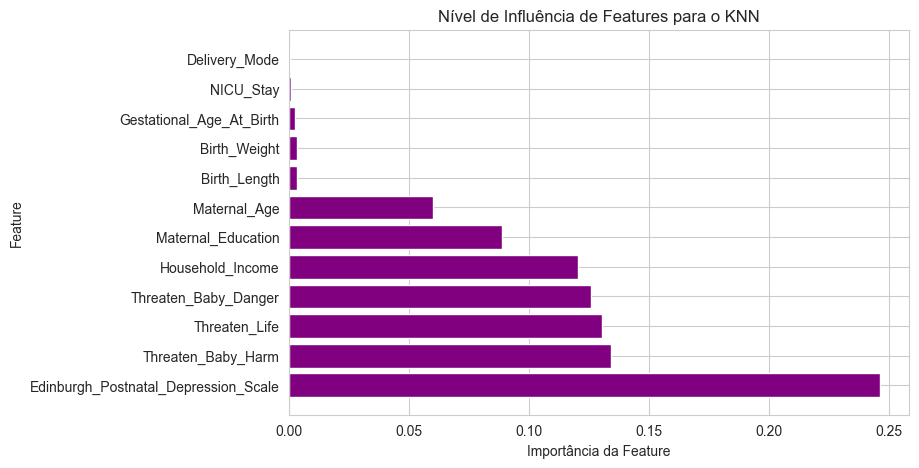

In [209]:
# Insights com o KNN

# descobrindo o nível de influência que cada feature possui no target obtido pleo modelo
pipeline.fit(df_features, df_target) 
result = permutation_importance(pipeline, df_features, df_target, n_repeats=10, random_state=42)

importances = result.importances_mean
feature_names = df_features.columns

feature_importance_df = pd.DataFrame({'feature': df_features.columns, 'importance': importances})

feature_groups = {
    'NICU_Stay': ['NICU_Stay_No', 'NICU_Stay_Unknown', 'NICU_Stay_Yes'],
    'Delivery_Mode': ['Delivery_Mode_Caesarean', 'Delivery_Mode_Unknown', 'Delivery_Mode_Vaginally']
}

# otimização pra features com one-hot encoding
grouped_importance = {}

for group, columns in feature_groups.items():
    grouped_importance[group] = feature_importance_df[feature_importance_df['feature'].isin(columns)]['importance'].sum()

for feature in df_features.columns:
    if feature not in [col for group in feature_groups.values() for col in group]:  # Evita duplicação
        grouped_importance[feature] = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].sum()

grouped_importance_df = pd.DataFrame.from_dict(grouped_importance, orient='index', columns=['importance'])
grouped_importance_df = grouped_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(grouped_importance_df.index, grouped_importance_df['importance'], color='purple')
plt.xlabel("Importância da Feature")
plt.ylabel("Feature")
plt.title("Nível de Influência de Features para o KNN")
plt.show()


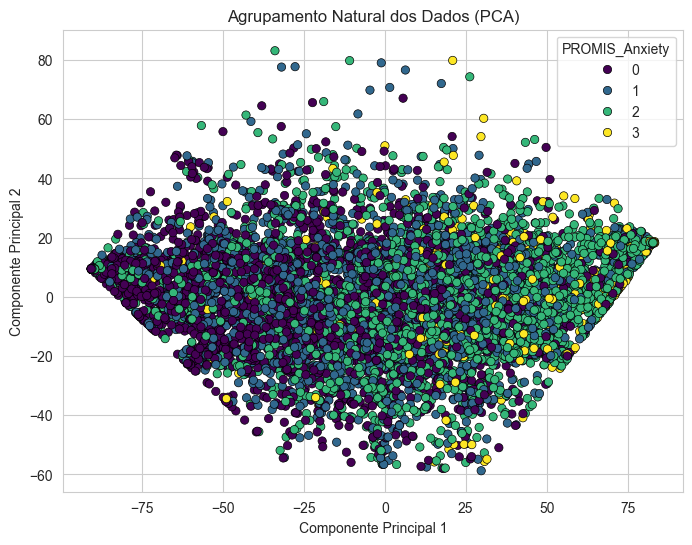

In [210]:
# visualizando o agrupamento natural dos dados
pca = PCA(n_components=2)  # Reduz para 2 dimensões
df_pca = pca.fit_transform(df_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_target, palette="viridis", edgecolor="k")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Agrupamento Natural dos Dados (PCA)")
plt.show()

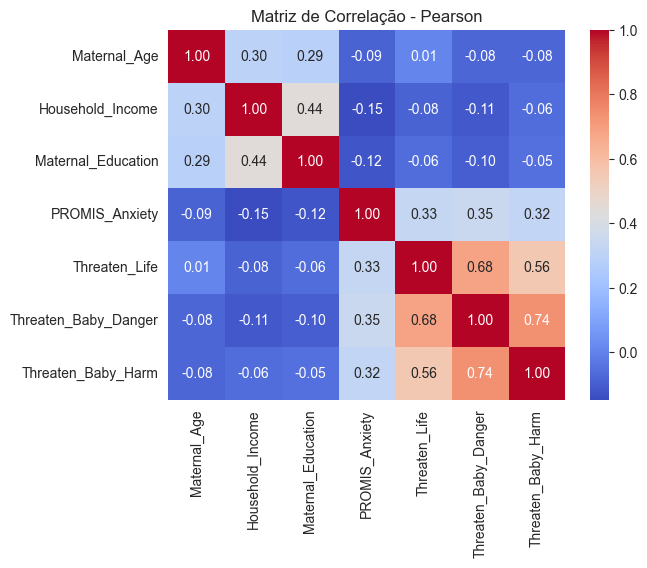

In [211]:
# Aplicando e Plotando a Correlação de Pearson
colunas_desejadas = ['Maternal_Age', 'Household_Income', 'Maternal_Education', 'PROMIS_Anxiety', 'Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']
correlacao = df[colunas_desejadas].corr(method='pearson')
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação - Pearson')
plt.show()

In [ ]:
#Conversão de 'Threaten_Baby_Harm' para numérico para utilização no modelo
df['Threaten_Baby_Harm'] = pd.to_numeric(df['Threaten_Baby_Harm'], errors='coerce')

In [ ]:
#Discretização e definição de features

# Discretização 'Threaten_Baby_Harm' usando a mediana.
median_val = df['Threaten_Baby_Harm'].median()
df['target_cat'] = (df['Threaten_Baby_Harm'] >= median_val).astype(int)
# Agora, 'target_cat' será 0 para valores abaixo da mediana e 1 para valores iguais ou acima da mediana.

# Definição das features e do target
features = ['Maternal_Age', 'PROMIS_Anxiety']
X = df[features]
y = df['target_cat']

In [ ]:
#Definição da 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
#Definição do modelo (Árvore de decisão)
model = DecisionTreeClassifier(random_state=42)

In [ ]:
#Execução dos experimentos com Árvore de decisão


from sklearn.metrics import accuracy_score


accuracies = []
f1_scores = []
exec_times = []

# Iteração por cada divisão definida no cross-validation
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Medição o tempo de treinamento e predição
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    exec_time = end_time - start_time
    
    # Calculo das métricas para este fold
    #Accuracy
    acc = accuracy_score(y_test, y_pred)
    #F1-score
    f1_val = f1_score(y_test, y_pred)
    
    accuracies.append(acc)
    f1_scores.append(f1_val)
    exec_times.append(exec_time)

# Calculo das médias dos 50 experimentos
accuracy_mean = np.mean(accuracies)
f1_mean = np.mean(f1_scores)
time_mean = np.mean(exec_times)

print(f"Decision Tree - Accuracy: {accuracy_mean:.3f}, F1-Score: {f1_mean:.3f}, Tempo médio: {time_mean:.4f} s")

Decision Tree - Accuracy: 0.622, F1-Score: 0.618, Tempo médio: 0.0056 s


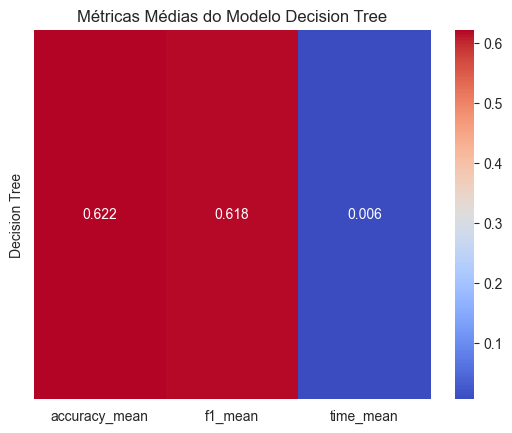

In [ ]:
#Visualização dos resultados
results = {'Decision Tree': {'accuracy_mean': accuracy_mean, 'f1_mean': f1_mean, 'time_mean': time_mean}}
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy_mean', 'f1_mean', 'time_mean']]

sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Métricas Médias do Modelo Decision Tree')
plt.show()

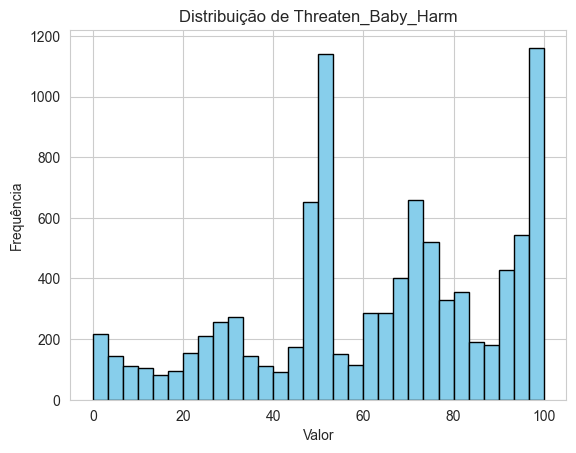

In [ ]:
#Visualizar a distribuição de 'Threaten_Baby_Harm'
plt.hist(df['Threaten_Baby_Harm'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição de Threaten_Baby_Harm')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()